<a href="https://colab.research.google.com/github/gunjansa/schoolofai/blob/main/Modular_SchoolOfAISession_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import utils
import model

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

CUDA Available? True


device(type='cuda')

CODE BLOCK: 3

In [ ]:
train_loader, test_loader = utils.create_mnist_dataloader()

CODE BLOCK: 4

CODE BLOCK: 5

CODE BLOCK: 6

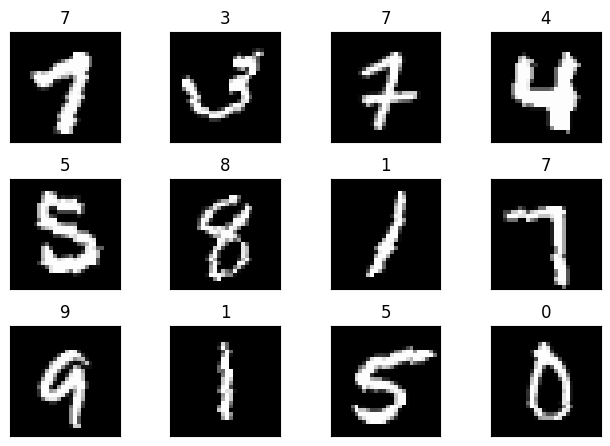

In [ ]:
utils.get_dataset_images(train_loader, 12)

CODE BLOCK: 7

CODE BLOCK: 8

CODE BLOCK: 9

CODE BLOCK: 10

In [ ]:
model_mnist = model.Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
optimizer = optim.SGD(model_mnist.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  model.train(model_mnist, device, train_loader, optimizer, criterion)
  model.test(model_mnist, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3953 Batch_id=117 Accuracy=55.61: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0006, Accuracy: 54685/60000 (91.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1775 Batch_id=117 Accuracy=94.19: 100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Test set: Average loss: 0.0003, Accuracy: 57551/60000 (95.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1042 Batch_id=117 Accuracy=96.52: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0002, Accuracy: 58217/60000 (97.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2255 Batch_id=117 Accuracy=97.18: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


Test set: Average loss: 0.0002, Accuracy: 58446/60000 (97.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0298 Batch_id=117 Accuracy=97.41: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0001, Accuracy: 58627/60000 (97.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0222 Batch_id=117 Accuracy=97.81: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


Test set: Average loss: 0.0001, Accuracy: 58859/60000 (98.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0875 Batch_id=117 Accuracy=98.03: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0001, Accuracy: 58897/60000 (98.16%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0244 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0001, Accuracy: 58967/60000 (98.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0199 Batch_id=117 Accuracy=98.38: 100%|██████████| 118/118 [00:26<00:00,  4.46it/s]


Test set: Average loss: 0.0001, Accuracy: 59100/60000 (98.50%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0377 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


Test set: Average loss: 0.0001, Accuracy: 59159/60000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0820 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0001, Accuracy: 59151/60000 (98.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0447 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:26<00:00,  4.42it/s]


Test set: Average loss: 0.0001, Accuracy: 59178/60000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0411 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0001, Accuracy: 59303/60000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0223 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


Test set: Average loss: 0.0001, Accuracy: 59355/60000 (98.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.1300 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0001, Accuracy: 59388/60000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0099 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0001, Accuracy: 59502/60000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0030 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0001, Accuracy: 59487/60000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0023 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.0001, Accuracy: 59498/60000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0090 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0001, Accuracy: 59528/60000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0234 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0001, Accuracy: 59514/60000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

In [ ]:
model.draw_graphs()

In [ ]:
model.get_model_summary(model_mnist, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [ ]:
t = torch.tensor(
    [[[1,1,0,2],
    [0,3,3,0],
    [4,0,2,5]],
    [[4,0,3,1],
    [0,7,7,0],
    [1,0,6,2]]])
t

tensor([[[1, 1, 0, 2],
         [0, 3, 3, 0],
         [4, 0, 2, 5]],

        [[4, 0, 3, 1],
         [0, 7, 7, 0],
         [1, 0, 6, 2]]])

In [ ]:
t.max(dim=2)

torch.return_types.max(
values=tensor([[2, 3, 5],
        [4, 7, 6]]),
indices=tensor([[3, 1, 3],
        [0, 1, 2]]))

In [ ]:
tt = torch.tensor([[1, 0, 0, 2], [0,3,3,0]]) # [x1, y1, z1, v1], [x2, y2, z2, v2]
tt

tensor([[1, 0, 0, 2],
        [0, 3, 3, 0]])

In [ ]:
tt.max(dim=0)

torch.return_types.max(
values=tensor([1, 3, 3, 2]),
indices=tensor([0, 1, 1, 0]))